# NISAR Access and Visualize

Authors: Sumant Jha (MSFC/USRA), Emile Tenezakis (DevSeed), Alex Mandel (DevSeed), Samuel Ayers (UAH)

Date: March 9, 2023

Description: In the following tutorial, we are going to look at how to access, read, and visualize simulated-NISAR data which is available from the NISAR mission. This mission is expected to launch in 2024. 

## Run This Notebook
To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.

## About the Data

Unmanned Aerial Vehicle Synthetic Aperture Radar (UAVSAR)

This tutorial currently uses UAVSAR data, which has the purpose of mapping crustal deformations associated with natural hazards. UAVSAR data can also include topographic data which are derived from phase measurements. If two or more passes are made, UAVSAR data can be used to detect changes on the surface of the Earth, and is overall a highly useful tool in monitoring natural hazards and disasters. (Source: [ESA eoPortal - UAVSAR](https://www.eoportal.org/other-space-activities/uavsar#uavsar-unmanned-aerial-vehicle-synthetic-aperture-radar))

Note: UAVSAR is a predecessor to NASA-ISRO Synthetic Aperture Radar (NISAR), which is a mission that will likely be launched in 2024. At this time we are using UAVSAR data to simulate the data that we will get from the NISAR satellite. 

## Additional Resources
- [Alaska Satellite Facility (ASF) UAVSAR](https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/)
- [JPL - NISAR Mission](https://nisar.jpl.nasa.gov/)
- [JPL - SAR Overview](https://nisar.jpl.nasa.gov/mission/get-to-know-sar/overview/)
- [ASF - SAR Media Resources](https://asf.alaska.edu/information/sar-information/fundamentals-of-synthetic-aperture-radar/)

## Import and Install Packages

Before we start any work, we will need to prepare our Jupyter workspace with the necessary python packages. In this tutorial we rely on - h5py, numpy, glob, os,  h5glance, osgeo, and matplotlib. 

You might have some or all packages already installed. Follow the instructions below to check and install the packages required for this tutorial. The block below will check if your packages are available and install them if they are not.

In [1]:
# %pip install h5py glob2 h5glance gdal matplotlib pystac-client

We also require that you have the gdal package installed out of the Jupyter environment to use: gdal_translate and gdalinfo. If on Mac OS, you might need to install the xcode package before being able to install gdal.

To install gdal outside the Jupyter environment, please follow the instructions here as it will vary by the OS you are using: https://gdal.org/download.html

Import installed packages to read the NISAR h5 files and look at the data structure.

In [2]:
import h5py
import glob
import os
from h5glance import H5Glance
from pystac_client import Client

## Download NISAR Data
NISAR data can be downloaded from https://uavsar.jpl.nasa.gov/cgi-bin/data.pl. At the time of this tutorial, there are 21033 NISAR products available through the above link. There are a few ways to download data that we can use. We can directly download an SLC file or we can download an H5 file and translate it to SLC to work with this tutorial. 
In this tutorial, we demonstrate how to get an H5 file, translate it to SLC and use it. Users can alternatively directly download SLC files.

We can browse the 129 NISAR mode products in the MAAP STAC catalog and retrieve its asset HREFs for download.

In [3]:
cat = Client.open('https://stac.maap-project.org/')

items = list(
    cat.search(
        collections="nisar-sim",
        max_items=10
    ).items()
)

In [4]:
item_assset = items[0].assets["CX_129.h5"].href

Before downloading, we'll create a new data directory to download the file into.

In [5]:
# set data directory
dataDir = "./data"

# check if directory exists -> if directory doesn't exist, directory is created
if not os.path.exists(dataDir):
    os.mkdir(dataDir)

In [6]:
# download the file using wget
!wget -P {dataDir} {item_assset}

--2023-09-18 14:52:57--  https://downloaduav.jpl.nasa.gov/Release2z/Haywrd_14501_21043_012_210602_L090_CX_02/Haywrd_14501_21043_012_210602_L090_CX_129_02.h5
Resolving downloaduav.jpl.nasa.gov (downloaduav.jpl.nasa.gov)... 137.78.249.121
Connecting to downloaduav.jpl.nasa.gov (downloaduav.jpl.nasa.gov)|137.78.249.121|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uavsar.jpl.nasa.gov/Release2z/Haywrd_14501_21043_012_210602_L090_CX_02/Haywrd_14501_21043_012_210602_L090_CX_129_02.h5 [following]
--2023-09-18 14:52:57--  https://uavsar.jpl.nasa.gov/Release2z/Haywrd_14501_21043_012_210602_L090_CX_02/Haywrd_14501_21043_012_210602_L090_CX_129_02.h5
Resolving uavsar.jpl.nasa.gov (uavsar.jpl.nasa.gov)... 137.78.249.121
Connecting to uavsar.jpl.nasa.gov (uavsar.jpl.nasa.gov)|137.78.249.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1750205900 (1.6G)
Saving to: ‘./data/Haywrd_14501_21043_012_210602_L090_CX_129_02.h5.

The file should now appear in the directory we created.

If you downloaded multiple H5 files, initialize an empty variable to store the names of all H5 files in the directory.

In [7]:
nisar_list = []

In [8]:
for file in glob.glob("./data*/*.h5"):
    nisar_list.append(file)
    print(file)

./data/Haywrd_14501_21043_012_210602_L090_CX_129_02.h5


In [9]:
nisar_list[0]

'./data/Haywrd_14501_21043_012_210602_L090_CX_129_02.h5'

## Explore the Data

Explore the structure of NISAR *.H5 file using H5glance.

In [10]:
H5Glance(nisar_list[0])

./data/Haywrd_14501_21043_012_210602_L090_CX_129_02.h5/ (6 attributes)
└science	(1 children)

## Convert the Data
Use gdal to convert HH polarization for frequencyA to ENVI SLC format and visualize it. 
(More example notebooks are provided here: https://github.com/isce-framework/sds-ondemand)

Before we go ahead and convert the HH polarization, check out the metadata information associated with it.

In [11]:
path = f"HDF5:{nisar_list[0]}://science/LSAR/SLC/swaths/frequencyA/HH"
!gdalinfo {path}

Driver: HDF5Image/HDF5 Dataset
Files: ./data/Haywrd_14501_21043_012_210602_L090_CX_129_02.h5
Size is 2640, 15404
Metadata:
  contact=nisarops@jpl.nasa.gov
  Conventions=CF-1.7
  institution=NASA JPL
  mission_name=NISAR
  reference_document=TBD
  title=NISAR L1 SLC Product
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,15404.0)
Upper Right ( 2640.0,    0.0)
Lower Right ( 2640.0,15404.0)
Center      ( 1320.0, 7702.0)
Band 1 Block=128x128 Type=CFloat32, ColorInterp=Undefined
  Metadata:
    science_LSAR_SLC_swaths_frequencyA_HH_description=Focused SLC image (HH)
    science_LSAR_SLC_swaths_frequencyA_HH_units=DN


Translate the HH polarization into SLC files. SLC files are Single Look Complex files. More information can be found in the product description [here](https://uavsar.jpl.nasa.gov/science/documents/nisar-sample-products.html#Product%20Description).

In [12]:
path = f"HDF5:{nisar_list[0]}://science/LSAR/SLC/swaths/frequencyA/HH HH.slc"
!gdal_translate -of ENVI {path}

Input file size is 2640, 15404
0...10...20...30...40...50...60...70...80...90...100 - done.


Check the metadata again. 

In [13]:
!gdalinfo HH.slc

Driver: ENVI/ENVI .hdr Labelled
Files: HH.slc
       HH.slc.aux.xml
       HH.hdr
Size is 2640, 15404
Metadata:
  contact=nisarops@jpl.nasa.gov
  Conventions=CF-1.7
  institution=NASA JPL
  mission_name=NISAR
  reference_document=TBD
  title=NISAR L1 SLC Product
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,15404.0)
Upper Right ( 2640.0,    0.0)
Lower Right ( 2640.0,15404.0)
Center      ( 1320.0, 7702.0)
Band 1 Block=2640x1 Type=CFloat32, ColorInterp=Undefined
  Metadata:
    science_LSAR_SLC_swaths_frequencyA_HH_description=Focused SLC image (HH)
    science_LSAR_SLC_swaths_frequencyA_HH_units=DN


## Visualize
Finally, lets plot amplitude and phase.

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[[ 2.46178992e-02-0.01162272j  2.06204206e-02+0.0438217j
   2.01302450e-02-0.00866299j ... -3.71712632e-03+0.00754739j
  -3.99701595e-02+0.01584719j  4.39935476e-02+0.03462401j]
 [-5.99635430e-02-0.04907523j -1.78322736e-02-0.04193708j
   4.85753343e-02-0.00152001j ... -3.92718357e-04+0.03611586j
   3.35564204e-02+0.0750533j  -2.58343443e-02+0.00963823j]
 [-1.27040278e-02+0.00876454j  9.38015990e-03+0.01417367j
  -1.09148119e-02-0.00828656j ... -1.72818732e-02-0.08329829j
   5.43021038e-03-0.03845887j -2.69295573e-02-0.03714512j]
 ...
 [-1.18659958e-02-0.04372251j -4.90541667e-01-0.04433485j
  -6.41287342e-02+0.12093218j ... -8.06556106e-01+0.35332313j
   2.51429707e-01-0.24497119j  2.09877625e-01+0.43311965j]
 [ 1.27028033e-01+0.08081798j -1.80030346e-01-0.05467323j
  -1.05361664e+00-0.45684314j ... -8.28622878e-01-0.33322746j
  -1.37368396e-01-0.42675552j  3.07213575e-01-0.02091259j]
 [ 1.09616600e-01-0.02663859j -1.23310655e-01+0.22490016j
  -9.74314928e-01+0.17205611j ... -4.843586

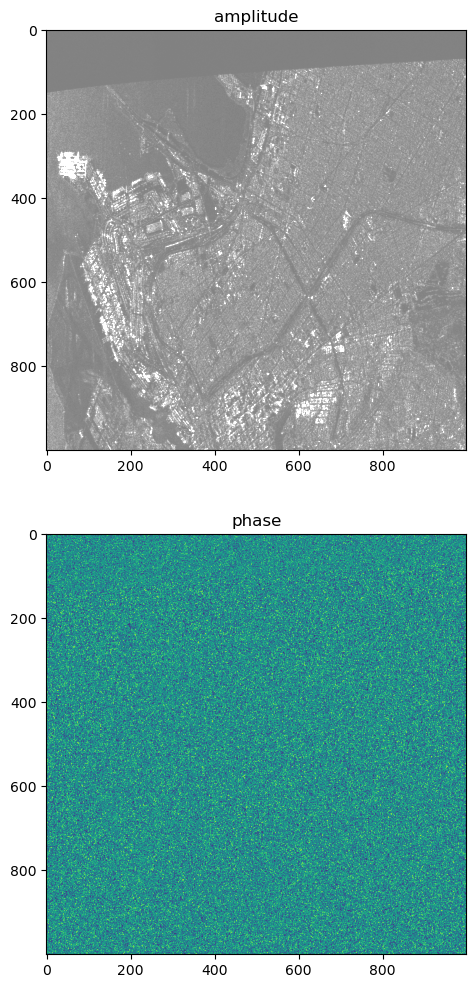

In [14]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt


# Extract a subset of the SLC to display
x0 = 0
y0 = 10
x_offset = 1000
y_offset = 1000

with rasterio.open("HH.slc") as ds:
    # Define the window of data to read
    window = rasterio.windows.Window(x0, y0, x_offset, y_offset)

    # Read the data from the specified window
    slc = ds.read(1, window=window)
    print(slc)

fig = plt.figure(figsize=(14, 12))

# Display amplitude of the slc
ax = fig.add_subplot(2, 1, 1)
ax.imshow(np.abs(slc), vmin=-2, vmax=2, cmap="gray")
ax.set_title("amplitude")

# Display phase of the slc
ax = fig.add_subplot(2, 1, 2)
ax.imshow(np.angle(slc))
ax.set_title("phase")

plt.show()